## Introduction

The dataset consists of data collected from adults with well-controlled Type 1 Diabetes who were randomized to either use Continuous Glucose Monitoring (CGM) alone or CGM with routine Blood Glucose Monitoring (BGM). It included metrics such as CGM glucose readings, frequency of blood glucose tests and Self-reported food intake. 

## Data loading

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler

import random
seed = 1

import torch
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# CGM Readings
df_cgm = pd.read_csv('replace-bg/Data Tables/HDeviceCGM.csv', index_col=0)

normalize_para = 100  
df_cgm["GlucoseValue"] = df_cgm["GlucoseValue"]/normalize_para 

# delete the columns that would not be used in analysis
df_cgm.drop(columns= ['RecID', 'SiteID', 'ParentHDeviceUploadsID'], inplace=True)

df_cgm.head()

,PtID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,2,140,22:58:05,141.0,05:54:19,CGM,0.91
1,2,140,22:53:05,141.0,05:49:19,CGM,0.90
2,2,140,22:48:05,141.0,05:44:20,CGM,0.90
3,2,140,22:43:05,141.0,05:39:19,CGM,0.88
4,2,140,22:38:05,141.0,05:34:19,CGM,0.86


In [3]:
# Dose of insulin injection
df_bolus = pd.read_csv('replace-bg/Data Tables/HDeviceBolus.csv', index_col=0)

# delete the columns that would not be used in analysis
df_bolus.drop(columns= ['RecID', 'SiteID', 'ParentHDeviceUploadsID'], inplace=True)

df_bolus.head()

,PtID,DeviceDtTmDaysFromEnroll,DeviceTm,BolusType,InjValue,Insulin,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,ExpectedDuration
0,7,-54,23:29:34,normal,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN
1,7,-54,20:56:01,normal,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN
2,7,-54,17:13:45,normal,NaN,NaN,3.1,NaN,NaN,NaN,NaN,NaN
3,7,-54,15:21:08,normal,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN
4,7,-54,13:07:37,normal,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN


In [4]:
# Self-reported food intake.
df_diet = pd.read_csv('replace-bg/Data Tables/HDeviceWizard.csv', index_col=0)

# Rename the column PtID
df_diet.rename(columns={'PtId': 'PtID'}, inplace=True)

# delete the columns that would not be used in analysis
df_diet.drop(columns= ['RecID', 'SiteID', 'ParentHDeviceUploadsID', 'ParentHDeviceBolusID'], inplace=True)

df_diet["CarbInput"] = df_diet["CarbInput"]/normalize_para 

df_diet.head()


,PtID,DeviceDtTmDaysFromEnroll,DeviceTm,RecommendedCarb,RecommendedCorrection,RecommendedNet,BgInput,CarbInput,InsulinOnBoard,InsulinCarbRatio,InsulinSensitivity,BgTargetLow,BgTargetHigh,BgTargetTarget,BgTargetRange
0,7,-57,20:20:24,2.0,0.0,2.0,0.00,0.23,0.0,11.0,3.05,3.89,8.33,NaN,NaN
1,7,-57,09:01:20,0.0,1.8,1.8,13.93,0.00,0.0,11.0,3.05,3.89,8.33,NaN,NaN
2,7,-58,17:37:57,3.6,0.0,3.6,0.00,0.40,0.0,11.0,3.05,3.89,8.33,NaN,NaN
3,7,-59,23:03:17,3.1,0.0,3.1,0.00,0.35,0.0,11.0,3.05,3.89,8.33,NaN,NaN
4,7,6,08:45:22,0.0,2.6,2.6,16.37,0.00,0.0,11.0,3.05,3.89,8.33,NaN,NaN


In [5]:
# merge all the datafile
df = df_cgm.merge(df_bolus, on=["PtID",  "DeviceDtTmDaysFromEnroll", "DeviceTm"], how='outer')
df = df.merge(df_diet, on=["PtID",  "DeviceDtTmDaysFromEnroll", "DeviceTm"], how='outer')

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477848 entries, 0 to 477847
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PtID                           477848 non-null  int64  
 1   DeviceDtTmDaysFromEnroll       477848 non-null  int64  
 2   DeviceTm                       477848 non-null  object 
 3   DexInternalDtTmDaysFromEnroll  458107 non-null  float64
 4   DexInternalTm                  458107 non-null  object 
 5   RecordType                     463484 non-null  object 
 6   GlucoseValue                   463484 non-null  float64
 7   BolusType                      13864 non-null   object 
 8   InjValue                       0 non-null       float64
 9   Insulin                        0 non-null       float64
 10  Normal                         13835 non-null   float64
 11  ExpectedNormal                 239 non-null     float64
 12  Extended                      

## Data exploration and preprocessing

This dataset includes only 7 participants.

In [6]:
# Define an arbitrary reference date
reference_date = pd.Timestamp('2015-03-01')

# Convert 'DeviceDtTmDaysFromEnroll' to timedelta and add to the enrollment date
df['Date'] = reference_date + pd.to_timedelta(df['DeviceDtTmDaysFromEnroll'], unit='D')

# Combine 'Date' with 'DeviceTm' to create a full datetime-like column
df['DeviceDateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['DeviceTm'])

# Drop the intermediate 'Date' column if not needed
df.drop(columns=['Date'], inplace=True)


# Retain only the variables relevant to the study
df = df[["PtID", "DeviceDateTime", "GlucoseValue", "CarbInput", "Normal"]]

df.head()

,PtID,DeviceDateTime,GlucoseValue,CarbInput,Normal
0,2,2015-07-19 22:58:05,0.91,NaN,NaN
1,2,2015-07-19 22:53:05,0.90,NaN,NaN
2,2,2015-07-19 22:48:05,0.90,NaN,NaN
3,2,2015-07-19 22:43:05,0.88,NaN,NaN
4,2,2015-07-19 22:38:05,0.86,NaN,NaN


In [7]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize an empty dictionary to store DataFrames for each patient
patient_data = {}

# Group the data by 'PtID' and iterate through each group
for patient_id, group in df.groupby('PtID'):
    # Reset the index of the group DataFrame
    patient_df = group.reset_index(drop=True)
    # Store the DataFrame in the dictionary with the patient ID as the key
    patient_data[patient_id] = patient_df.sort_values(by='DeviceDateTime').reset_index(drop=True)
    
    # Convert timestamp to float
    patient_data[patient_id]['time'] = pd.to_datetime(patient_data[patient_id]["DeviceDateTime"])
    min_time = patient_data[patient_id]['time'].min()
    patient_data[patient_id]['time'] = (patient_data[patient_id]['time'] - min_time).dt.total_seconds()
    
    time_reshaped = patient_data[patient_id]['time'].values.reshape(-1, 1)
    patient_data[patient_id]['time'] = scaler.fit_transform(time_reshaped)


# Display the resulting DataFrames for each patient
for patient_id, data in patient_data.items():
    print(f"PatientID {patient_id}:")
    print(data)
    print()

PatientID 2:
       PtID      DeviceDateTime  GlucoseValue  CarbInput  Normal      time
0         2 2014-10-29 22:48:21           NaN        0.0    2.15  0.000000
1         2 2014-10-30 07:37:21           NaN        0.0    4.93  0.001008
2         2 2014-10-30 08:27:02           NaN        NaN    1.00  0.001103
3         2 2014-10-30 19:52:28           NaN        NaN    3.00  0.002409
4         2 2014-10-30 22:49:31           NaN        0.0    0.29  0.002747
...     ...                 ...           ...        ...     ...       ...
69426     2 2015-10-29 07:33:58          0.81        NaN     NaN  0.999959
69427     2 2015-10-29 07:38:58          0.80        NaN     NaN  0.999969
69428     2 2015-10-29 07:43:58          0.80        NaN     NaN  0.999978
69429     2 2015-10-29 07:48:58          0.79        NaN     NaN  0.999988
69430     2 2015-10-29 07:55:18          0.78        NaN     NaN  1.000000

[69431 rows x 6 columns]

PatientID 3:
       PtID      DeviceDateTime  GlucoseValue  

In [22]:
for patient_id, data in patient_data.items():   
    # Calculate the range of 'DeviceDateTime'
    date_range = patient_data[patient_id]['DeviceDateTime'].max() - patient_data[patient_id]['DeviceDateTime'].min()

    # Extract the number of days
    days_range = date_range.days
    several_day = 288*days_range
    tt = np.array(range(several_day))
    min_length = min(len(tt), len(patient_data[patient_id]['GlucoseValue'][:several_day]))
    tt = tt[:min_length]

    # plt.figure()
    plt.figure(figsize=(30,10))
    
    # remove invalid values before plotting
    import copy
    plot_insulin = copy.deepcopy(patient_data[patient_id]['Normal'][:several_day])
    plot_insulin[plot_insulin==0] = None
    plot_Meal = copy.deepcopy(patient_data[patient_id]['CarbInput'][:several_day])
    plot_Meal[plot_Meal==0] = None

    plt.plot(tt, patient_data[patient_id]['GlucoseValue'][:several_day], 'b-*', tt, plot_Meal, 'r-o', tt, plot_insulin, 'y-d')

    # The glucose levels between the pink line and the green line are normal glucose levels
    plt.plot(tt, 0.7*np.ones(min_length),'pink', tt, 1.8*np.ones(min_length), 'green')

    plt.legend(loc='upper right', fontsize=16, labels=['Glucose (100 mg/dL)', 'Meal (100 mg)', 'Insulin (U)'])
    plt.xlabel('Samples every 5 mins')
    plt.ylabel('100 mg/dL; Unit; 100 g')
    plt.title(f"Time series data for PatientID {patient_id}", fontsize=16)
    # Save the plot to a file
    plt.savefig(f"Time series data for PatientID {patient_id}.png")


KeyError: 'DeviceDateTime'

The table below contains the proportion of each participants's glucose value in target, hypoglycemia and hyperglycemia.

In [8]:
# Initialize a DataFrame to store the results of time proportion
results = pd.DataFrame(columns=['Participant', 'Target Proportion', 'Hypoglycemia Proportion', 'Hyperglycemia Proportion'])

# Calculate Time Proportions in Different Glucose Ranges
for patient_id, data in patient_data.items():

    # Calculate time differences between consecutive readings
    patient_data[patient_id]['time_diff'] = patient_data[patient_id]['DeviceDateTime'].diff().dt.total_seconds() / 60.0  # convert to minutes
    patient_data[patient_id] = patient_data[patient_id].dropna(subset=['DeviceDateTime'])

    # Calculate time proportions
    time_in_target = patient_data[patient_id][(patient_data[patient_id]['GlucoseValue'] >= 0.7) & (patient_data[patient_id]['GlucoseValue'] <= 1.8)]['time_diff'].sum()
    time_in_hypo = patient_data[patient_id][patient_data[patient_id]['GlucoseValue'] < 0.7]['time_diff'].sum()
    time_in_hyper = patient_data[patient_id][patient_data[patient_id]['GlucoseValue'] > 1.8]['time_diff'].sum()
    total_time = patient_data[patient_id]['time_diff'].sum()
    
    # Calculate proportions
    target_proportion = time_in_target / total_time
    hypo_proportion = time_in_hypo / total_time
    hyper_proportion = time_in_hyper / total_time
    
    # Append the results to the DataFrame
    results = results.append({
        'Participant': patient_id,
        'Target Proportion': target_proportion,
        'Hypoglycemia Proportion': hypo_proportion,
        'Hyperglycemia Proportion': hyper_proportion
    }, ignore_index=True)

results   

,Participant,Target Proportion,Hypoglycemia Proportion,Hyperglycemia Proportion
0,2.0,0.536365,0.032556,0.085670
1,3.0,0.346295,0.024241,0.227459
2,5.0,0.405498,0.018456,0.129049
3,7.0,0.382585,0.031112,0.267188
4,8.0,0.470416,0.026201,0.229351
5,9.0,0.699977,0.017044,0.268714
6,10.0,0.346997,0.008571,0.002239


In [9]:
# Initialize a DataFrame to store the results
meal_stats_df = pd.DataFrame(columns=['Participant', 'Meal Mean', 'Meal Std', 'Meal Min', 'Meal 25%', 'Meal 50%', 'Meal 75%', 'Meal Max'])
insulin_stats_df = pd.DataFrame(columns=['Participant', 'Insulin Mean', 'Insulin Std', 'Insulin Min', 'Insulin 25%', 'Insulin 50%', 'Insulin 75%', 'Insulin Max'])

for patient_id, data in patient_data.items():
    meal_stats = patient_data[patient_id]["CarbInput"].describe()
    meal_stats_df = meal_stats_df.append({
        'Participant': patient_id,
        'Meal Mean': meal_stats['mean'],
        'Meal Std': meal_stats['std'],
        'Meal Min': meal_stats['min'],
        'Meal 25%': meal_stats['25%'],
        'Meal 50%': meal_stats['50%'],
        'Meal 75%': meal_stats['75%'],
        'Meal Max': meal_stats['max']
    }, ignore_index=True)

    insulin_stats = patient_data[patient_id]["Normal"].describe()
    insulin_stats_df = insulin_stats_df.append({
        'Participant': patient_id,
        'Insulin Mean': insulin_stats['mean'],
        'Insulin Std': insulin_stats['std'],
        'Insulin Min': insulin_stats['min'],
        'Insulin 25%': insulin_stats['25%'],
        'Insulin 50%': insulin_stats['50%'],
        'Insulin 75%': insulin_stats['75%'],
        'Insulin Max': insulin_stats['max']
    }, ignore_index=True)

# Display the results
print("Meal Statistics for Each Participant")
print(meal_stats_df)

print("\nInsulin Statistics for Each Participant")
insulin_stats_df

Meal Statistics for Each Participant
   Participant  Meal Mean  Meal Std  Meal Min  Meal 25%  Meal 50%  Meal 75%  \
0          2.0   0.110147  0.238432       0.0    0.0000      0.00      0.08   
1          3.0   0.444516  0.334413       0.0    0.2000      0.40      0.70   
2          5.0   0.204589  0.118066       0.0    0.1400      0.20      0.28   
3          7.0   0.307577  0.303832       0.0    0.0000      0.24      0.46   
4          8.0   0.268037  0.208069       0.0    0.0575      0.28      0.42   
5          9.0        NaN       NaN       NaN       NaN       NaN       NaN   
6         10.0   0.100846  0.138883       0.0    0.0000      0.05      0.15   

   Meal Max  
0      1.62  
1      1.60  
2      0.70  
3      2.20  
4      1.20  
5       NaN  
6      0.80  

Insulin Statistics for Each Participant


,Participant,Insulin Mean,Insulin Std,Insulin Min,Insulin 25%,Insulin 50%,Insulin 75%,Insulin Max
0,2.0,2.068465,1.540255,0.00,1.00,2.00,3.00,9.00
1,3.0,4.457466,2.523360,0.25,2.50,4.00,6.00,18.60
2,5.0,3.928035,2.132622,0.10,2.00,3.20,5.00,15.00
3,7.0,2.321795,1.794913,0.03,1.10,1.90,3.00,15.50
4,8.0,1.723561,0.962745,0.00,1.00,1.50,2.22,11.34
5,9.0,1.022414,0.753862,0.00,0.55,0.75,1.35,9.68
6,10.0,2.140264,1.596181,0.00,0.88,1.67,3.16,9.92


There are missing data in "GlucoseValue", "CarbInput" and "Normal"(ie. there are missing data in glucose value, selff-reported food intake and dose of insulin injection). I use forward fill and backward fill to do imputation in glucose value. I filled missing values in other columns with 0.

In [10]:
# Check for missing values
print(df.isnull().sum())

# fill the glucose value with a forward fill and backward fill
for patient_id, data in patient_data.items():
    # fill missing values
    patient_data[patient_id]['GlucoseValue'] = patient_data[patient_id]['GlucoseValue'].fillna(method='ffill').fillna(method='bfill')
    patient_data[patient_id] = patient_data[patient_id].fillna(0)
    
    patient_data[patient_id] = patient_data[patient_id].drop('DeviceDateTime', axis=1)

    patient_data[patient_id] = patient_data[patient_id].drop('PtID', axis=1)

    patient_data[patient_id] = patient_data[patient_id].drop('time_diff', axis=1)

PtID                   0
DeviceDateTime         0
GlucoseValue       14364
CarbInput         470737
Normal            464013
dtype: int64


The table below indicates the distribution of each person's glucose value.

In [12]:
glucose_dist_df = pd.DataFrame(columns=['Participant', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'])

# check the distribution of glucose value of each participant
for patient_id, data in patient_data.items():
    glucose_dist = patient_data[patient_id]["GlucoseValue"].describe()
    glucose_dist_df = glucose_dist_df.append({
        'Participant': patient_id,
        'Mean': glucose_dist['mean'],
        'Std': glucose_dist['std'],
        'Min': glucose_dist['min'],
        '25%': glucose_dist['25%'],
        '50%': glucose_dist['50%'],
        '75%': glucose_dist['75%'],
        'Max': glucose_dist['max']
    }, ignore_index=True)

glucose_dist_df

,Participant,Mean,Std,Min,25%,50%,75%,Max
0,2.0,1.273527,0.476169,0.39,0.92,1.17,1.52,4.11
1,3.0,1.660100,0.645447,0.39,1.17,1.60,2.07,4.01
2,5.0,1.489043,0.517181,0.39,1.13,1.43,1.78,4.01
3,7.0,1.655664,0.643063,0.39,1.16,1.60,2.08,4.01
4,8.0,1.590477,0.646142,0.39,1.10,1.48,1.96,4.01
5,9.0,1.549289,0.475410,0.39,1.20,1.52,1.85,3.52
6,10.0,0.973307,0.205615,0.39,0.84,0.93,1.06,2.88


## Dataset partitioning

divide the dataset into 70% training dataset, 10% validation dataset, 20% testing dataset

In [13]:
def _load_data(data, n_prev = 24):
    """
    data should be in the type of pd.DataFrame()
    """
    pred_window = 6
    X_list, Y_list = [], []
    for i in range(data.shape[0]-n_prev-pred_window):
        X_list.append(data[i:(i + n_prev)])
        Y_list.append(data[i + n_prev + pred_window - 1][0]) # here 'pred_window = 6' represents 30 minutes
    X = np.array(X_list)
    Y = np.array(Y_list)
    
    return X, Y

def train_valid_test_split(data, n_prev=24):

    X, Y = _load_data(data, n_prev)
    total_len = len(data)
    train_end = int(total_len * 0.8 * 0.875)
    valid_end = int(total_len * 0.8) 

    X_train, Y_train = X[:train_end], Y[:train_end]
    X_valid, Y_valid = X[train_end:valid_end], Y[train_end:valid_end]
    X_test, Y_test = X[valid_end:], Y[valid_end:]


    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

## Model training

Applying SVM and RNN to modell the cgm data.

### For participant ID 2:

#### SVM

In [67]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[2].to_numpy())

from sklearn.svm import SVR
# Fit SV regression model
svr_rbf_2 = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf_2 = svr_rbf_2.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf_2 * normalize_para

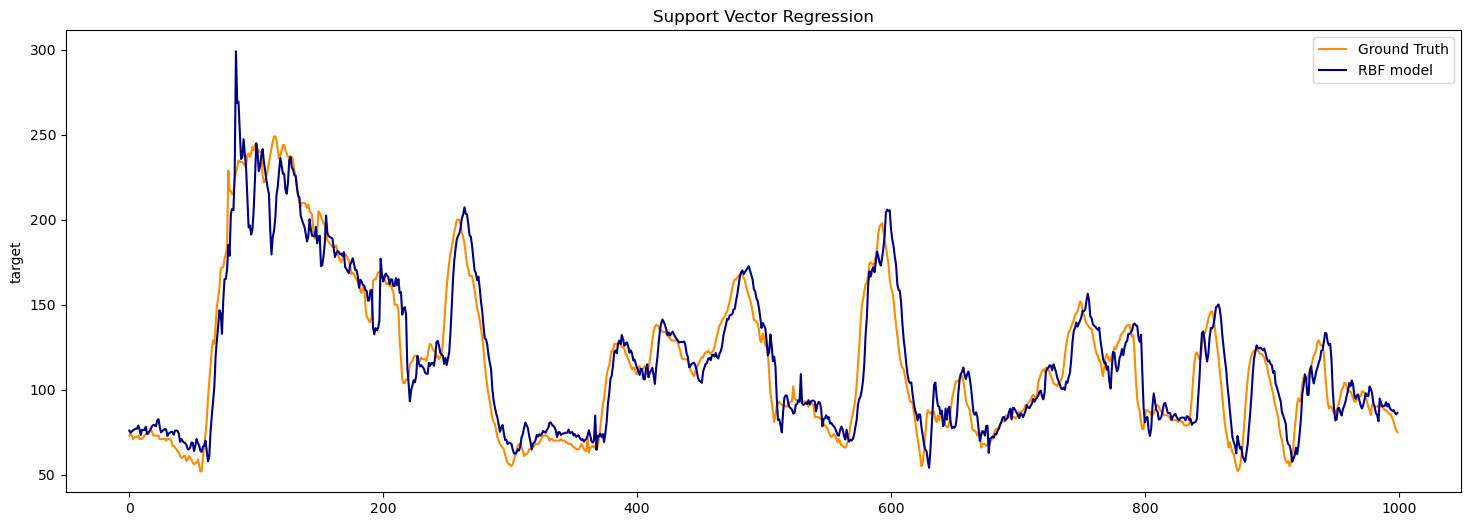

In [68]:
# show results
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:1000], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:1000], color='navy', label='RBF model')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [78]:
# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:15.44846379486357
MARD:9.711728498436415


#### RNN (sequential model)

In [17]:
from torch.utils.data import Dataset, RandomSampler, TensorDataset
import torch
class Mydataset(Dataset):
    def __init__(self, X, y):
        self.y = y
        self.X = X
    def __len__(self):
            return len(self.y)
    def __getitem__(self, idx):
        y_idx = self.y[idx]
        X_idx = self.X[idx]
            
        return (X_idx,y_idx)

train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def train_model(model, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 

    max_val_loss = np.inf
    best_model = None

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training


        for i, data in enumerate(train_loader, 0):
            X_train_batch, y_train_batch = data
            # clear the gradients of all optimized variables
            model.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            model.to(device)
            output = model(X_train_batch.to(device))   
            # predict the different between the future glucose and the last item of glucose time series
            label = y_train_batch.to(device)             # calculate the loss
            loss = criterion(output, label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():
            for data, target in valid_loader:
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data.to(device))
                # predict the different between the future glucose and the last item of glucose time series
                label = target.to(device)
                # calculate the loss
                loss = criterion(output, label)
                
                # record validation loss
                valid_losses.append(loss.item())
            
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        if valid_loss < max_val_loss:
            max_val_loss = valid_loss
            best_model = copy.deepcopy(model)

        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        
  
    return  best_model, avg_train_losses, avg_valid_losses

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
class LSTMNetworks(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, 
                            bidirectional = True, # declare bidirectional LSTM
                            batch_first = True)
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1),
        )
        self.hidden_size = hidden_size
        
    def forward(self, X):
        
        B, T, C = X.shape

        hc = None

        res, hc = self.lstm(X, hc)

        # forward and backward are directions 0 and 1 respectively.
        res = res.view(B, T, 2, self.hidden_size)
        out = torch.cat([res[:, -1, 0, :], res[:, 0, 1, :]], dim=-1)
        
        pred = self.output(out)

        return pred    
model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

LSTMNetworks(
  (lstm): LSTM(4, 50, batch_first=True, bidirectional=True)
  (output): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [84]:
best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.19607 valid_loss: 0.03547
[ 2/20] train_loss: 0.11547 valid_loss: 0.03210
[ 3/20] train_loss: 0.08752 valid_loss: 0.03033
[ 4/20] train_loss: 0.07321 valid_loss: 0.03002
[ 5/20] train_loss: 0.06447 valid_loss: 0.02932
[ 6/20] train_loss: 0.05863 valid_loss: 0.02880
[ 7/20] train_loss: 0.05437 valid_loss: 0.02846
[ 8/20] train_loss: 0.05120 valid_loss: 0.02816
[ 9/20] train_loss: 0.04871 valid_loss: 0.02782
[10/20] train_loss: 0.04669 valid_loss: 0.02777
[11/20] train_loss: 0.04503 valid_loss: 0.02770
[12/20] train_loss: 0.04366 valid_loss: 0.02752
[13/20] train_loss: 0.04250 valid_loss: 0.02748
[14/20] train_loss: 0.04151 valid_loss: 0.02735
[15/20] train_loss: 0.04063 valid_loss: 0.02724
[16/20] train_loss: 0.03986 valid_loss: 0.02736
[17/20] train_loss: 0.03918 valid_loss: 0.02721
[18/20] train_loss: 0.03857 valid_loss: 0.02715
[19/20] train_loss: 0.03803 valid_loss: 0.02705
[20/20] train_loss: 0.03753 valid_loss: 0.02693


The performance of both models are shown above, and Random forest classifier outperforms SVM classifier.

In [25]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

In [26]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:25.451914211625695
MARD:13.113039879266289


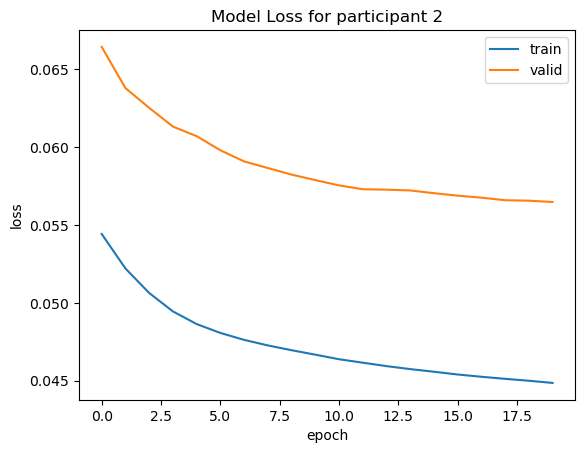

In [27]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

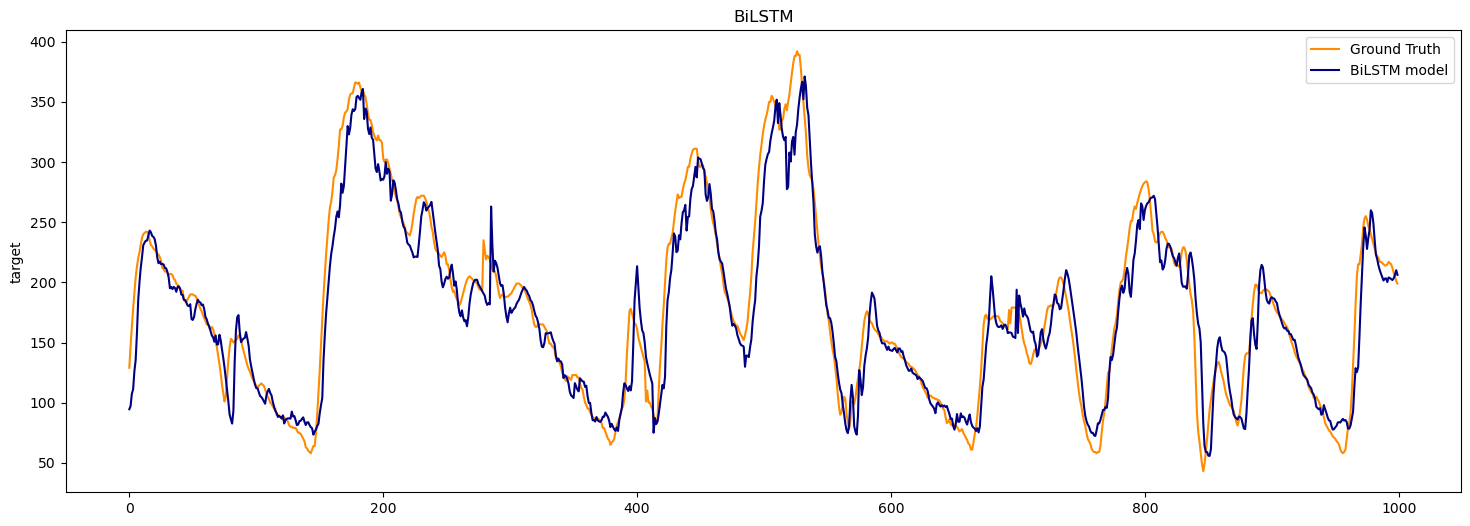

In [28]:
# show results
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:1000], color='darkorange', label='Ground Truth')
plt.plot(lstm_prediction[:1000], color='navy', label='BiLSTM model')
plt.ylabel('target')
plt.title('BiLSTM')
plt.legend()
plt.show()

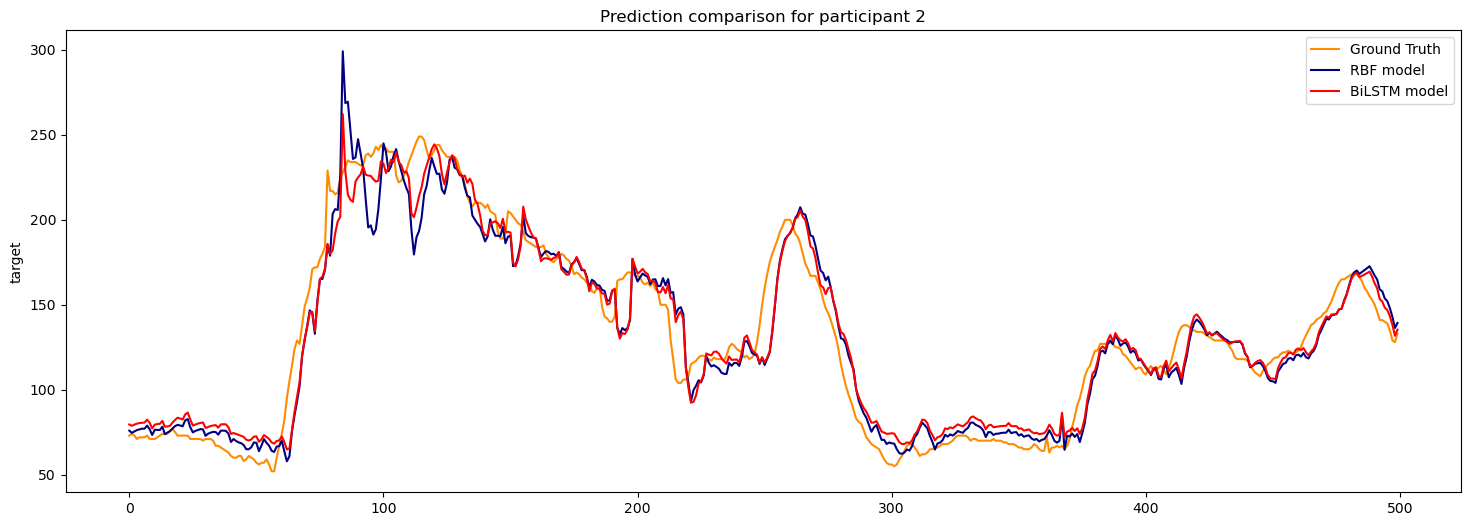

In [91]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 2')
plt.legend()
plt.show()

### For participant 3:

#### SVM

In [14]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[3].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

In [15]:
# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:28.182610155862935
MARD:13.727393498901236


#### RNN

In [20]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

LSTMNetworks(
  (lstm): LSTM(4, 50, batch_first=True, bidirectional=True)
  (output): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [24]:
best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.05442 valid_loss: 0.06643
[ 2/20] train_loss: 0.05220 valid_loss: 0.06379
[ 3/20] train_loss: 0.05063 valid_loss: 0.06252
[ 4/20] train_loss: 0.04945 valid_loss: 0.06132
[ 5/20] train_loss: 0.04864 valid_loss: 0.06071
[ 6/20] train_loss: 0.04807 valid_loss: 0.05980
[ 7/20] train_loss: 0.04762 valid_loss: 0.05908
[ 8/20] train_loss: 0.04726 valid_loss: 0.05866
[ 9/20] train_loss: 0.04696 valid_loss: 0.05823
[10/20] train_loss: 0.04667 valid_loss: 0.05788
[11/20] train_loss: 0.04638 valid_loss: 0.05754
[12/20] train_loss: 0.04615 valid_loss: 0.05729
[13/20] train_loss: 0.04593 valid_loss: 0.05727
[14/20] train_loss: 0.04574 valid_loss: 0.05722
[15/20] train_loss: 0.04557 valid_loss: 0.05704
[16/20] train_loss: 0.04540 valid_loss: 0.05688
[17/20] train_loss: 0.04525 valid_loss: 0.05675
[18/20] train_loss: 0.04512 valid_loss: 0.05659
[19/20] train_loss: 0.04499 valid_loss: 0.05656
[20/20] train_loss: 0.04485 valid_loss: 0.05648


In [29]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:25.451914211625695
MARD:13.113039879266289


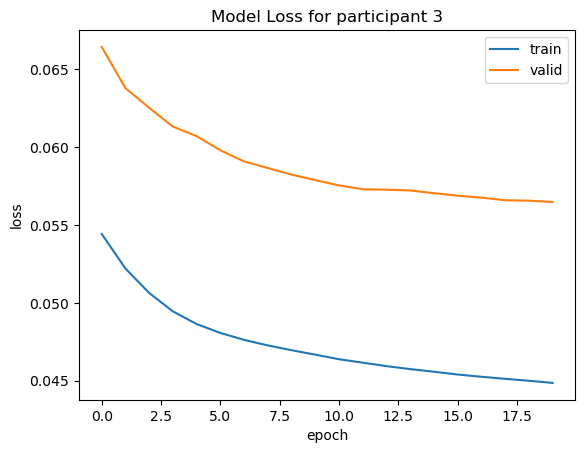

In [30]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

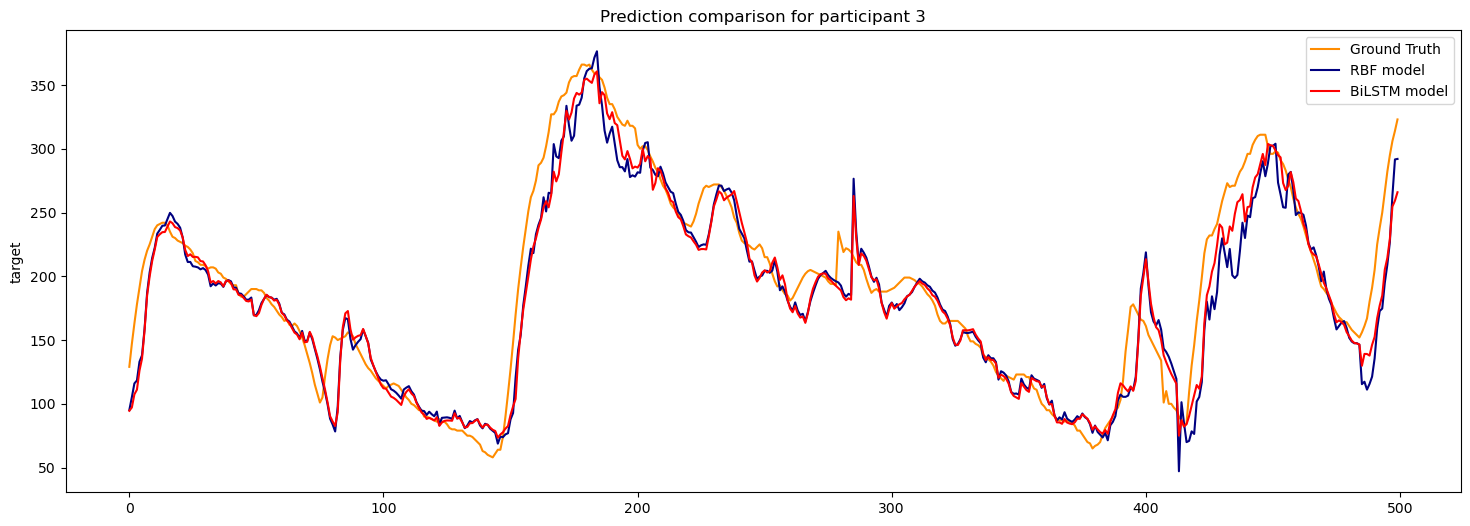

In [31]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 3')
plt.legend()
plt.show()

### For participant 5:

#### SVM

In [32]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[5].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

In [33]:
# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:24.846136348098074
MARD:11.221457106013874


#### RNN

In [34]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.31211 valid_loss: 0.04713
[ 2/20] train_loss: 0.17943 valid_loss: 0.04317
[ 3/20] train_loss: 0.13358 valid_loss: 0.04051
[ 4/20] train_loss: 0.11010 valid_loss: 0.03927
[ 5/20] train_loss: 0.09570 valid_loss: 0.03787
[ 6/20] train_loss: 0.08600 valid_loss: 0.03730
[ 7/20] train_loss: 0.07897 valid_loss: 0.03669
[ 8/20] train_loss: 0.07365 valid_loss: 0.03626
[ 9/20] train_loss: 0.06948 valid_loss: 0.03595
[10/20] train_loss: 0.06615 valid_loss: 0.03556
[11/20] train_loss: 0.06340 valid_loss: 0.03541
[12/20] train_loss: 0.06109 valid_loss: 0.03522
[13/20] train_loss: 0.05913 valid_loss: 0.03490
[14/20] train_loss: 0.05745 valid_loss: 0.03479
[15/20] train_loss: 0.05597 valid_loss: 0.03481
[16/20] train_loss: 0.05469 valid_loss: 0.03472
[17/20] train_loss: 0.05357 valid_loss: 0.03462
[18/20] train_loss: 0.05254 valid_loss: 0.03448
[19/20] train_loss: 0.05161 valid_loss: 0.03448
[20/20] train_loss: 0.05079 valid_loss: 0.03442


In [35]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:20.33369946443099
MARD:9.91127129545728


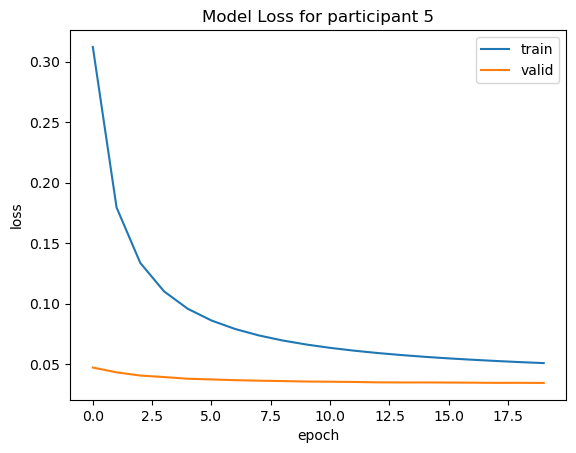

In [36]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

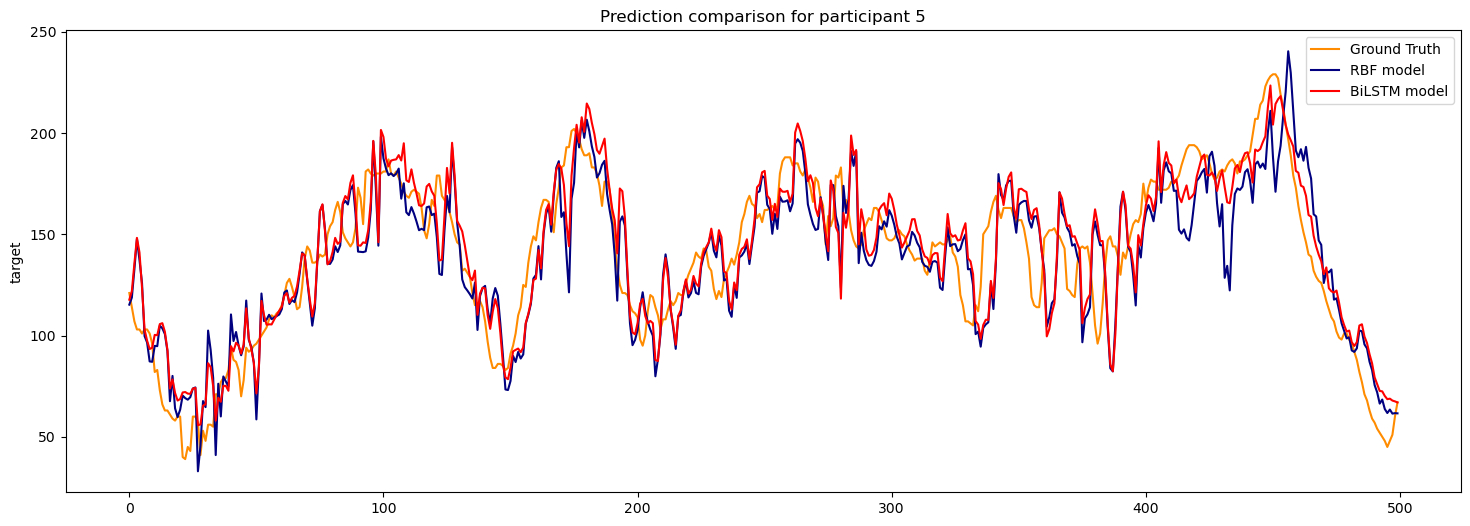

In [37]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 5')
plt.legend()
plt.show()

### For participant 7:

#### SVM

In [38]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[7].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

In [39]:
# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:23.30352726211703
MARD:11.939955889137634


#### RNN

In [40]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.27298 valid_loss: 0.06477
[ 2/20] train_loss: 0.16587 valid_loss: 0.05866
[ 3/20] train_loss: 0.12832 valid_loss: 0.05426
[ 4/20] train_loss: 0.10897 valid_loss: 0.05160
[ 5/20] train_loss: 0.09708 valid_loss: 0.05001
[ 6/20] train_loss: 0.08902 valid_loss: 0.05042
[ 7/20] train_loss: 0.08324 valid_loss: 0.04925
[ 8/20] train_loss: 0.07885 valid_loss: 0.04881
[ 9/20] train_loss: 0.07544 valid_loss: 0.05247
[10/20] train_loss: 0.07279 valid_loss: 0.05227
[11/20] train_loss: 0.07050 valid_loss: 0.05141
[12/20] train_loss: 0.06864 valid_loss: 0.05076
[13/20] train_loss: 0.06702 valid_loss: 0.05014
[14/20] train_loss: 0.06558 valid_loss: 0.04975
[15/20] train_loss: 0.06431 valid_loss: 0.04928
[16/20] train_loss: 0.06324 valid_loss: 0.04883
[17/20] train_loss: 0.06225 valid_loss: 0.04840
[18/20] train_loss: 0.06136 valid_loss: 0.04801
[19/20] train_loss: 0.06055 valid_loss: 0.04782
[20/20] train_loss: 0.05983 valid_loss: 0.04761


In [41]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:21.44131255391986
MARD:10.758648868358508


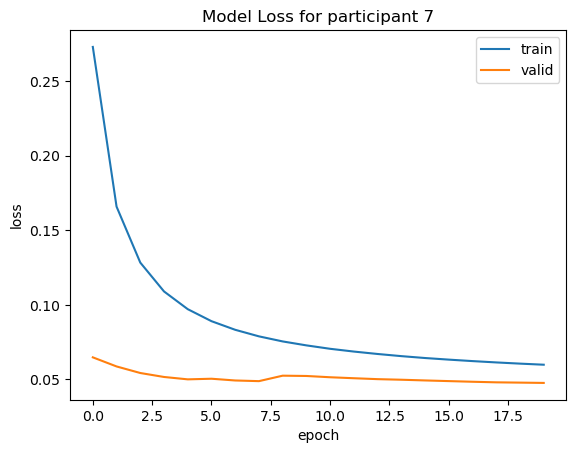

In [42]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 7')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

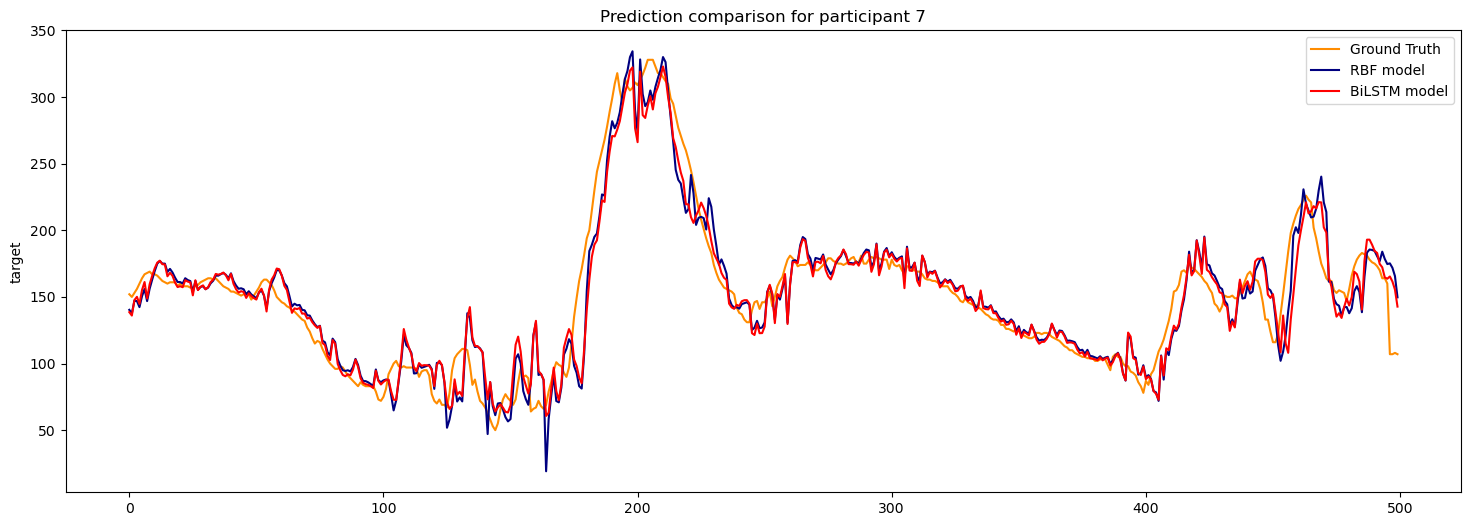

In [43]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 7')
plt.legend()
plt.show()

### For participant 8

##### SVM

In [44]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[8].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:20.70778043877838
MARD:11.2112789187796


#### RNN

In [45]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.30129 valid_loss: 0.09316
[ 2/20] train_loss: 0.18363 valid_loss: 0.09022
[ 3/20] train_loss: 0.14231 valid_loss: 0.08431
[ 4/20] train_loss: 0.12092 valid_loss: 0.08212
[ 5/20] train_loss: 0.10818 valid_loss: 0.07975
[ 6/20] train_loss: 0.09928 valid_loss: 0.07803
[ 7/20] train_loss: 0.09286 valid_loss: 0.07817
[ 8/20] train_loss: 0.08799 valid_loss: 0.07734
[ 9/20] train_loss: 0.08416 valid_loss: 0.07614
[10/20] train_loss: 0.08108 valid_loss: 0.07513
[11/20] train_loss: 0.07856 valid_loss: 0.07445
[12/20] train_loss: 0.07645 valid_loss: 0.07375
[13/20] train_loss: 0.07462 valid_loss: 0.07358
[14/20] train_loss: 0.07304 valid_loss: 0.07321
[15/20] train_loss: 0.07167 valid_loss: 0.07318
[16/20] train_loss: 0.07049 valid_loss: 0.07284
[17/20] train_loss: 0.06941 valid_loss: 0.07243
[18/20] train_loss: 0.06844 valid_loss: 0.07225
[19/20] train_loss: 0.06756 valid_loss: 0.07197
[20/20] train_loss: 0.06676 valid_loss: 0.07196


In [46]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:19.596293462270545
MARD:10.809463706133025


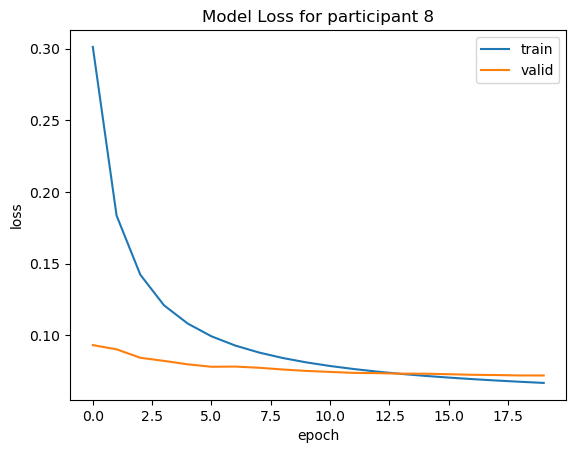

In [47]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 8')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

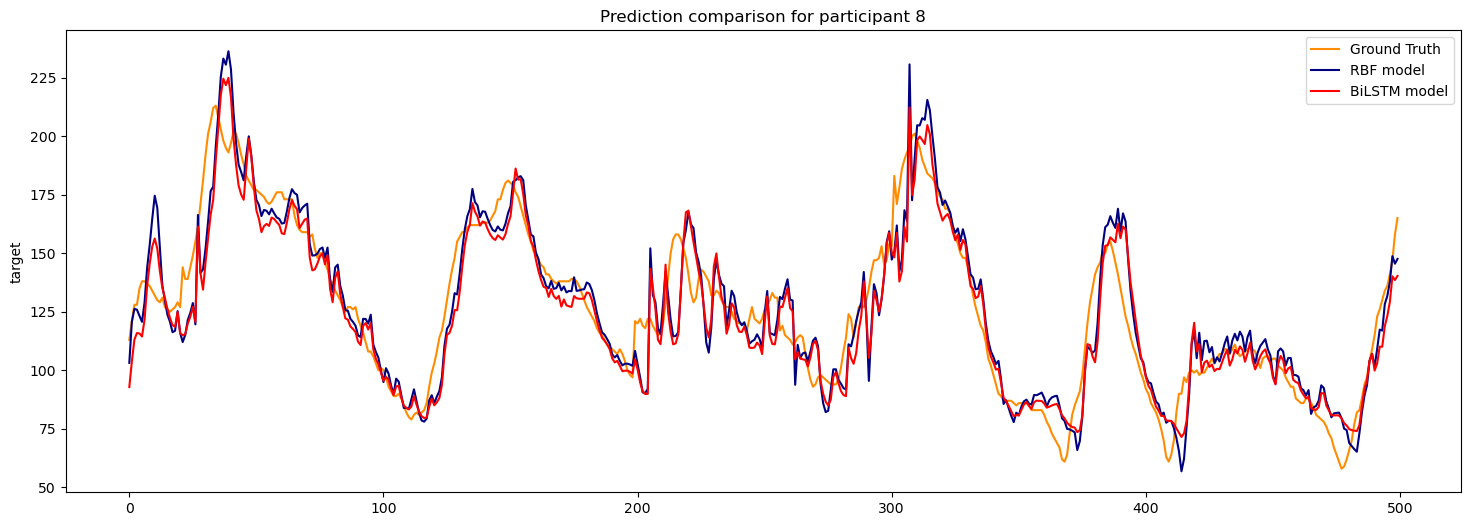

In [48]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 8')
plt.legend()
plt.show()

### For participant 9:

#### SVM

In [49]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[9].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:22.43244346989887
MARD:11.594348519473504


#### RNN

In [50]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.17829 valid_loss: 0.03831
[ 2/20] train_loss: 0.10888 valid_loss: 0.03915
[ 3/20] train_loss: 0.08423 valid_loss: 0.03622
[ 4/20] train_loss: 0.07144 valid_loss: 0.03702
[ 5/20] train_loss: 0.06368 valid_loss: 0.03537
[ 6/20] train_loss: 0.05848 valid_loss: 0.03446
[ 7/20] train_loss: 0.05473 valid_loss: 0.03381
[ 8/20] train_loss: 0.05187 valid_loss: 0.03385
[ 9/20] train_loss: 0.04964 valid_loss: 0.03334
[10/20] train_loss: 0.04784 valid_loss: 0.03339
[11/20] train_loss: 0.04634 valid_loss: 0.03297
[12/20] train_loss: 0.04509 valid_loss: 0.03267
[13/20] train_loss: 0.04401 valid_loss: 0.03243
[14/20] train_loss: 0.04308 valid_loss: 0.03227
[15/20] train_loss: 0.04227 valid_loss: 0.03222
[16/20] train_loss: 0.04156 valid_loss: 0.03210
[17/20] train_loss: 0.04093 valid_loss: 0.03192
[18/20] train_loss: 0.04038 valid_loss: 0.03174
[19/20] train_loss: 0.03986 valid_loss: 0.03158
[20/20] train_loss: 0.03940 valid_loss: 0.03149


In [51]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:16.00933667005273
MARD:6.8894271900535315


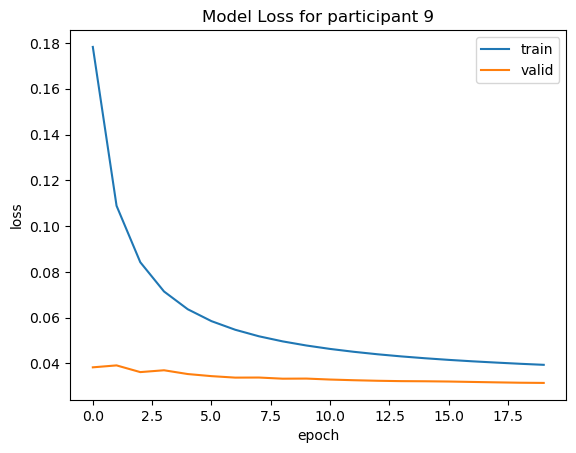

In [52]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

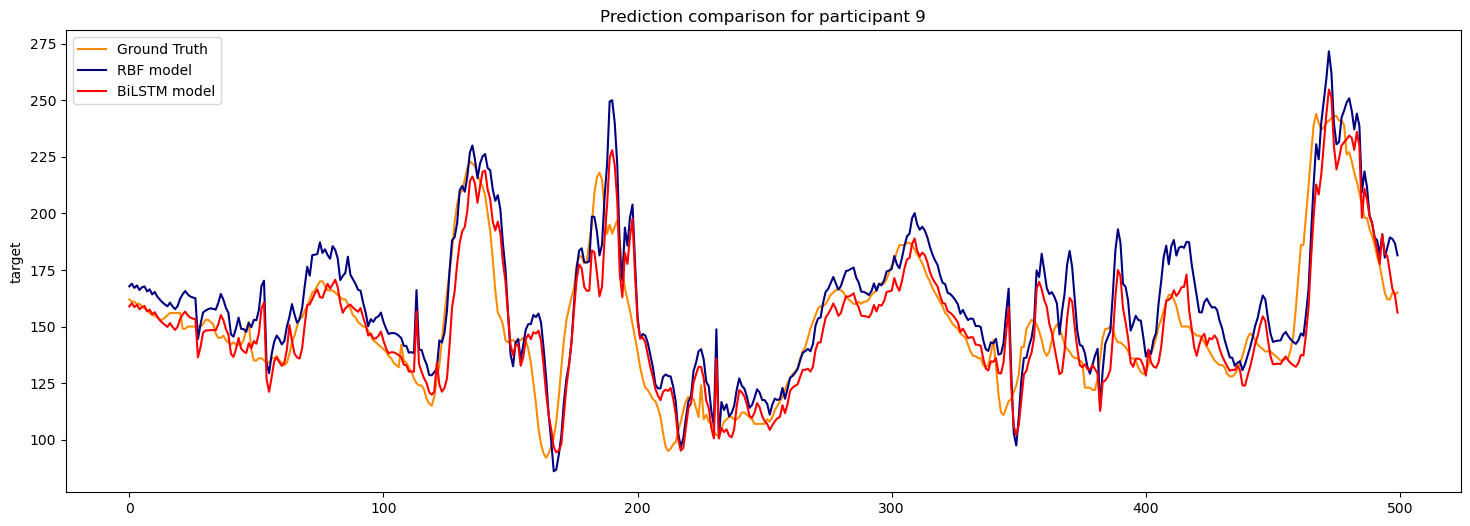

In [53]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 9')
plt.legend()
plt.show()

### For participant 10:

#### SVM


In [54]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = train_valid_test_split(patient_data[10].to_numpy())

# Fit SV regression model
svr_rbf = SVR(kernel='rbf', C=0.1e3, gamma=0.01,cache_size=1000)
# fit model
y_rbf = svr_rbf.fit(X_train.reshape(X_train.shape[0], -1), Y_train).predict(X_test.reshape(X_test.shape[0], -1))

Y_test_renorm = Y_test * normalize_para
svr_prediction = y_rbf * normalize_para

# calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test_renorm, svr_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, svr_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:11.492818185247915
MARD:7.45205958427724


#### RNN

In [55]:
train_dataset = Mydataset(np.array(X_train, dtype=np.float32), Y_train.astype(np.float32)[:, None])
valid_dataset = Mydataset(np.array(X_valid, dtype=np.float32), Y_valid.astype(np.float32)[:, None])
test_dataset = Mydataset(np.array(X_test, dtype=np.float32), Y_test.astype(np.float32)[:, None])


batch_size = 128

train_random = RandomSampler(train_dataset)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, sampler=train_random
                                            )

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=batch_size,
                                            )

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                           )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LSTMNetworks(input_size=X_train.shape[-1], hidden_size = 50)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

best_model, avg_train_losses, avg_valid_losses = train_model(model, 20)

[ 1/20] train_loss: 0.05711 valid_loss: 0.01500
[ 2/20] train_loss: 0.03523 valid_loss: 0.01330
[ 3/20] train_loss: 0.02765 valid_loss: 0.01322
[ 4/20] train_loss: 0.02374 valid_loss: 0.01271
[ 5/20] train_loss: 0.02135 valid_loss: 0.01236
[ 6/20] train_loss: 0.01973 valid_loss: 0.01217
[ 7/20] train_loss: 0.01855 valid_loss: 0.01198
[ 8/20] train_loss: 0.01765 valid_loss: 0.01195
[ 9/20] train_loss: 0.01696 valid_loss: 0.01184
[10/20] train_loss: 0.01639 valid_loss: 0.01176
[11/20] train_loss: 0.01594 valid_loss: 0.01168
[12/20] train_loss: 0.01555 valid_loss: 0.01165
[13/20] train_loss: 0.01523 valid_loss: 0.01158
[14/20] train_loss: 0.01494 valid_loss: 0.01153
[15/20] train_loss: 0.01469 valid_loss: 0.01156
[16/20] train_loss: 0.01448 valid_loss: 0.01152
[17/20] train_loss: 0.01429 valid_loss: 0.01148
[18/20] train_loss: 0.01412 valid_loss: 0.01145
[19/20] train_loss: 0.01397 valid_loss: 0.01146
[20/20] train_loss: 0.01383 valid_loss: 0.01142


In [56]:
best_model.eval() # prep model for evaluation
prediction = []
all_target = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = best_model(data.to(device))
    # record validation loss
    prediction.append(output.detach().cpu().numpy())

lstm_prediction = np.concatenate(prediction, axis=0)
lstm_prediction = lstm_prediction[:, 0] * normalize_para

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# calculate metrics
Y_test_renorm = Y_test * normalize_para
rmse = np.sqrt(mean_squared_error(Y_test_renorm, lstm_prediction))
mape = 100 * mean_absolute_percentage_error(Y_test_renorm, lstm_prediction)
print('RMSE:{}'.format(rmse))
print('MARD:{}'.format(mape))

RMSE:11.359562854724096
MARD:7.4204318988177365


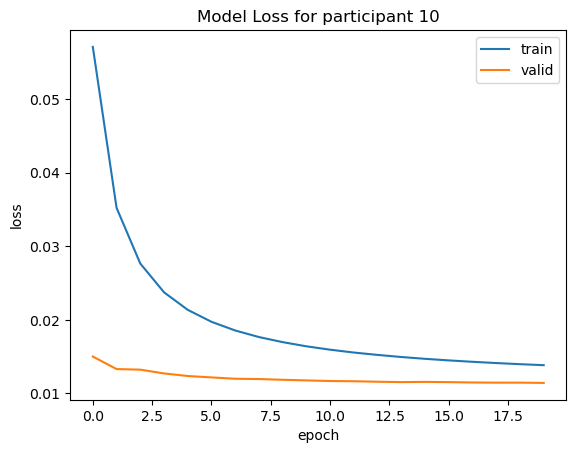

In [57]:
# Model Loss
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('Model Loss for participant 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

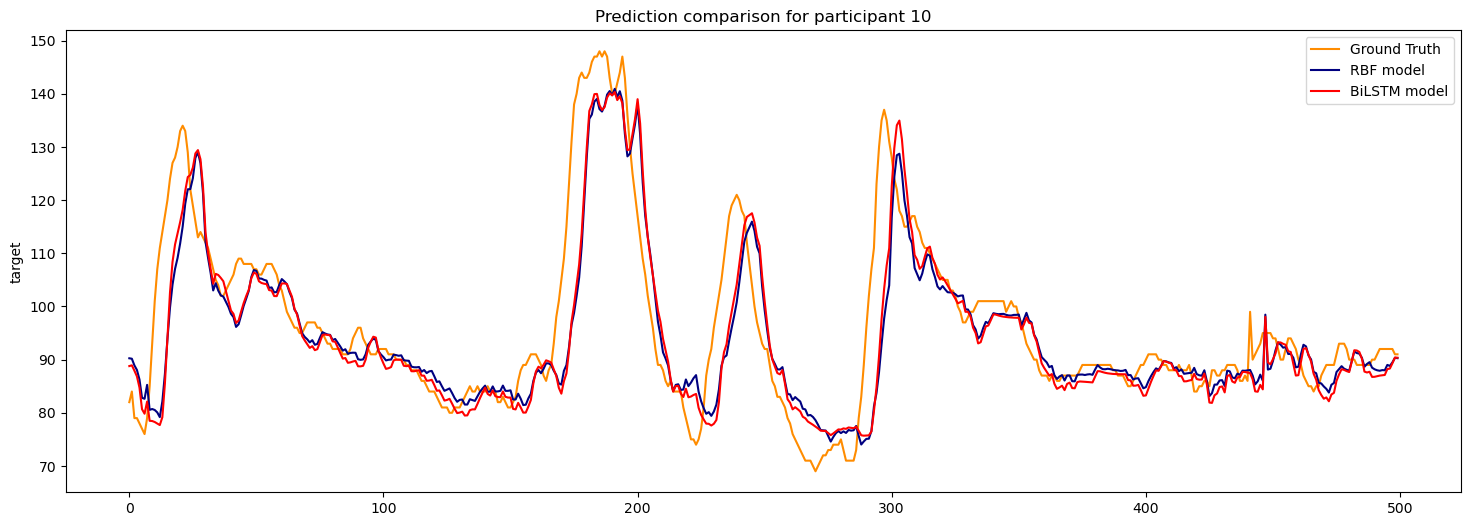

In [58]:
plt.figure(figsize=(18,6))
plt.plot(Y_test_renorm[:500], color='darkorange', label='Ground Truth')
plt.plot(svr_prediction[:500], color='navy', label='RBF model')
plt.plot(lstm_prediction[:500], color='red', label='BiLSTM model')
plt.ylabel('target')
plt.title('Prediction comparison for participant 10')
plt.legend()
plt.show()